# Assignments:
For this assignment I will design a new ligand for a particular target protein. the asignment will consist of 3 parts:

- bioinformatics: I will gather data about the target protein and ligand
- cheminformatics: I will create a machine learning model to predict affinities for novel ligands
- docking: I try to dock the ligands using Autodock vina

Joris Bak
s1680374

In [1]:
import nglview
import os
import shutil

from Bio.PDB import PDBList, MMCIFParser, Select, PDBIO
import Bio.Align
import os
from pathlib import Path
import rdkit

from scripts import viewer
from scripts import bio_align

from skimage import io

from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

filterwarnings("ignore")
SEED = 22

import py3Dmol

import pandas as pd
import glob
import sys

from vina import Vina

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

import nglview
from scripts import viewer

import sys, os, shutil
sys.path.insert(1, '/project/jhllei001/JHL_data/Jupyter_Dock/utilities')


import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

/opt/conda/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(


# Background:

cyclooxygenase-2 (COX-2) is an enzyme that plays a crucial role in the inflammatory response 
and is involved in the synthesis of prostaglandins, which are lipid compounds that mediate various physiological 
processes in the body. COX-2 is not typically found in most tissues under normal conditions but is induced at sites 
of inflammation. In contrast, COX-1 is constitutively expressed in many tissues and is involved in maintaining normal 
physiological functions, including the protection of the gastric mucosa. COX-2 produces biological mediators called 
prostaglandins which are produced from arachidonic acid. these lipids promotes inflammation and sensetizes pain neurons. This sensitization leads to an increased 
perception of pain. This is why COX-2 is a target for drugs that treat inflammation and pain. 
including these drugs are the well known NSIADs like aspirin (A01AD05), ibuprofen (M01AE01 ) or acetaminophen (N02BE01). However COX-2 overexpression is also linked to some forms of cancer. Therefor it will be valuable to design a ligand for COX-2 with a potent inhibitory effect which could be usefull in the treatment of these kind of cancers. 

cite: Mitchell JA, Warner TD. Cyclo-oxygenase-2: pharmacology, physiology, biochemistry and relevance to NSAID therapy. Br J Pharmacol. 1999 Nov;128(6):1121-32. doi: 10.1038/sj.bjp.0702897. PMID: 10578123; PMCID: PMC1571744.
PDB DOI:  https://doi.org/10.2210/pdb5F1A/pdb


# bioinformatics:

First I am going to compare the target protein to closley related proteins. I will assess the similarity of the target protein with a related protein in the human body and with a similar protein in another animal.

COX-2 sequence information from uniprot:

Length: 604
Mass (Da): 68,996
status: complete

similar protein in other animal:

western lowland gorilla:
Prostaglandin-endoperoxide synthase 2
length: 604
Mass (Da) 68,977

similar protein in humans:

Prostaglandin G/H synthase 1 (COX-1)
length: 599
Mass (Da): 68,686





CLUSTAL O(1.2.4) multiple sequence alignment


tr|G3RPV2|G3RPV2_GORGO      --------------MLARALLLCAVLALSHTANPCCSHPCQNRGVCMSVGFDQYKCDCTR	46
sp|P35354|PGH2_HUMAN        --------------MLARALLLCAVLALSHTANPCCSHPCQNRGVCMSVGFDQYKCDCTR	46
sp|P23219|PGH1_HUMAN        MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGICVRFGLDRYQCDCTR	60
                                          :*    :* *  .    .**** :***::*:*: .*:*:*:*****

tr|G3RPV2|G3RPV2_GORGO      TGFYGENCSTPEFLTRIKLFLKPTPNTVHYILTHFKGFWNVVNNIPFLRNAIMSYVLTSR	106
sp|P35354|PGH2_HUMAN        TGFYGENCSTPEFLTRIKLFLKPTPNTVHYILTHFKGFWNVVNNIPFLRNAIMSYVLTSR	106
sp|P23219|PGH1_HUMAN        TGYSGPNCTIPGLWTWLRNSLRPSPSFTHFLLTHGRWFWEFVN-ATFIREMLMRLVLTVR	119
                            **: * **: * : * ::  *:*:*. .*::*** : **:.**   *:*: :*  *** *

tr|G3RPV2|G3RPV2_GORGO      SHLIDSPPTYNADYGYKSWEAFSNLSYYTRALPPVPDDCPTPLGVKGKKQLPDSNEIVEK	166
sp|P35354|PGH2_HUMAN        SHLIDSPPTYNADYGYKSWEAFSNLSYYTRALPPVPDDCPTPLGVKGKKQLPDSNEIVEK	166
sp|P23219|PGH1_HUMAN        SNLIPSPPTYNSAHDYISWESFSNVSYYTRILPSVPKDCPTPMGTKGKKQLPDAQLLARR	179
                            *:** ******: :.* ***:***:***** ** **.*****:*.********:: :..:

tr|G3RPV2|G3RPV2_GORGO      LLLRRKFIPDPQGSNMMFAFFAQHFTHQFFKTDHKRGPAFTNGLGHGVDLNHIYGETLAR	226
sp|P35354|PGH2_HUMAN        LLLRRKFIPDPQGSNMMFAFFAQHFTHQFFKTDHKRGPAFTNGLGHGVDLNHIYGETLAR	226
sp|P23219|PGH1_HUMAN        FLLRRKFIPDPQGTNLMFAFFAQHFTHQFFKTSGKMGPGFTKALGHGVDLGHIYGDNLER	239
                            :************:*:****************. * **.**:.*******.****:.* *

tr|G3RPV2|G3RPV2_GORGO      QHKLRLFKDGKMKYQIIDGEMYPPTVKDTQAEMIYPPQVPEHLRFAVGQEVFGLVPGLMM	286
sp|P35354|PGH2_HUMAN        QRKLRLFKDGKMKYQIIDGEMYPPTVKDTQAEMIYPPQVPEHLRFAVGQEVFGLVPGLMM	286
sp|P23219|PGH1_HUMAN        QYQLRLFKDGKLKYQVLDGEMYPPSVEEAPVLMHYPRGIPPQSQMAVGQEVFGLLPGLML	299
                            * :********:***::*******:*::: . * **  :* : ::*********:****:

tr|G3RPV2|G3RPV2_GORGO      YATIWLREHNRVCDVLKQEHPEWGDEQLFQTSRLILIGETIKIVIEDYVQHLSGYHFKLK	346
sp|P35354|PGH2_HUMAN        YATIWLREHNRVCDVLKQEHPEWGDEQLFQTSRLILIGETIKIVIEDYVQHLSGYHFKLK	346
sp|P23219|PGH1_HUMAN        YATLWLREHNRVCDLLKAEHPTWGDEQLFQTTRLILIGETIKIVIEEYVQQLSGYFLQLK	359
                            ***:**********:** *** *********:**************:***:****.::**

tr|G3RPV2|G3RPV2_GORGO      FDPELLFNKQFQYQNRIAAEFNTLYHWHPLLPDTFQIHDQKYNYQQFIYNNSILLEHGIT	406
sp|P35354|PGH2_HUMAN        FDPELLFNKQFQYQNRIAAEFNTLYHWHPLLPDTFQIHDQKYNYQQFIYNNSILLEHGIT	406
sp|P23219|PGH1_HUMAN        FDPELLFGVQFQYRNRIAMEFNHLYHWHPLMPDSFKVGSQEYSYEQFLFNTSMLVDYGVE	419
                            *******. ****:**** *** *******:**:*:: .*:*.*:**::*.*:*:::*: 

tr|G3RPV2|G3RPV2_GORGO      QFVESFTRQIAGRVAGGRNVPPAVQKVSQASIDQSRQMKYQSFNEYRKRFMLKPYESFEE	466
sp|P35354|PGH2_HUMAN        QFVESFTRQIAGRVAGGRNVPPAVQKVSQASIDQSRQMKYQSFNEYRKRFMLKPYESFEE	466
sp|P23219|PGH1_HUMAN        ALVDAFSRQIAGRIGGGRNMDHHILHVAVDVIRESREMRLQPFNEYRKRFGMKPYTSFQE	479
                             :*::*:******:.****:   : :*:   * :**:*: * ******** :*** **:*

tr|G3RPV2|G3RPV2_GORGO      LTGEKEMSAELEALYGDIDAVELYPALLVEKPRPDAIFGETMVEVGAPFSLKGLMGNVIC	526
sp|P35354|PGH2_HUMAN        LTGEKEMSAELEALYGDIDAVELYPALLVEKPRPDAIFGETMVEVGAPFSLKGLMGNVIC	526
sp|P23219|PGH1_HUMAN        LVGEKEMAAELEELYGDIDALEFYPGLLLEKCHPNSIFGESMIEIGAPFSLKGLLGNPIC	539
                            *.*****:**** *******:*:**.**:** :*::****:*:*:*********:** **

tr|G3RPV2|G3RPV2_GORGO      SPAYWKPSTFGGEVGFQIINTASIQSLICNNVKGCPFTSFSVPDPELIKTVTINASSSRS	586
sp|P35354|PGH2_HUMAN        SPAYWKPSTFGGEVGFQIINTASIQSLICNNVKGCPFTSFSVPDPELIKTVTINASSSRS	586
sp|P23219|PGH1_HUMAN        SPEYWKPSTFGGEVGFNIVKTATLKKLVCLNTKTCPYVSFRVPDASQDDGPAVERPSTEL	599
                            ** *************:*::**:::.*:* *.* **:.** *** .  .  :::  *:. 

tr|G3RPV2|G3RPV2_GORGO      GLDDINPTVLLKERSTEL	604
sp|P35354|PGH2_HUMAN        GLDDINPTVLLKERSTEL	604
sp|P23219|PGH1_HUMAN        ------------------	599

the gorilla protein was 99.83% similar while the COX-1 enzyme was 61.71% similar. the same protein in a different animal is more similar than another related protein in humans. this is logical because these proteins share the same functions and therefor should have a vary similar structure. The sequence alligment sometimes does not show properly when copied above so for clarity I also added it in png form in the next cell.

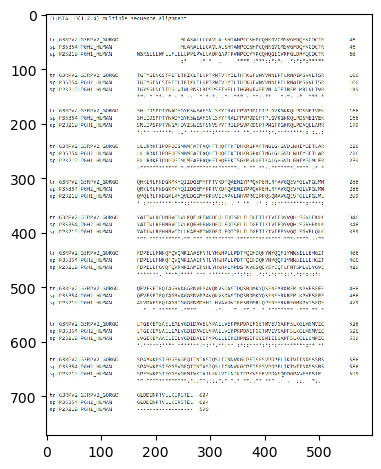

In [2]:
img = io.imread("sequence_alligment.png")
io.imshow(img)

Next I will compare COX-2 with human COX-1 on a structure basis. the code below shows the strucutal alligment. 
It may be hard to see but the structures are very similar between the two proteins.

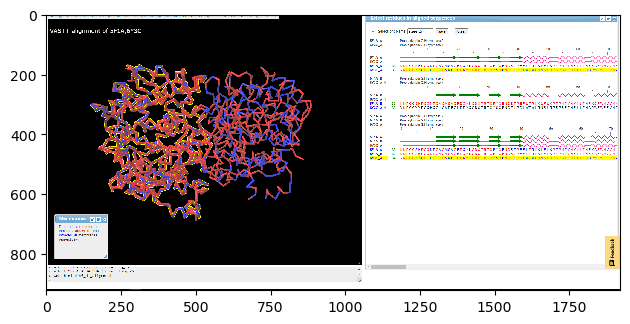

In [3]:
img = io.imread("alligment.png")
io.imshow(img)

Now I will prepare a .pbd file for the protein and ligands so they can be worked on. First we make a directory and we reterieve the target protein and its co-crystalized ligand. In this case that will be salycilate acid. We will view the retrieved molecules.

In [4]:
import os
from pathlib import Path
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('final_data')
except:
    print("Directory already exists")
os.chdir('final_data')

Directory already exists


In [5]:
TARGET_PDB_ID = "5F1A" # Enter your target PDB code here, example = '5N2R'
view = nglview.show_pdbid(TARGET_PDB_ID)
view.center()
view

NGLWidget()

In [6]:
LIGAND_CODE = "SAL" # Enter the ligand code here, example = 'zma'

view.center(LIGAND_CODE)
view

NGLWidget()

I will also look at the risiduals around this ligand

In [7]:
viewer.show_residues_around(view, selection=LIGAND_CODE)
view


NGLWidget()

Now I add the hydrogen atoms and split the protein and ligand to save them seperately.

In [8]:
pdbl = PDBList()
pdbl.retrieve_pdb_file(TARGET_PDB_ID, pdir=TARGET_PDB_ID)

parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/{}.cif'.format(TARGET_PDB_ID,TARGET_PDB_ID.lower()))

class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == LIGAND_CODE:
            return 1
        else:
            return 0

class NonHetSelect(Select):
    def accept_residue(self, residue):
        return 1 if residue.id[0] == " " else 0

io = PDBIO()
io.set_structure(structure)
io.save("ligand-{}.pdb".format(LIGAND_CODE), ResSelect())
io.save("protein-{}.pdb".format(TARGET_PDB_ID), NonHetSelect())

command = '../CBR_teaching/bin/lepro protein-{}.pdb'.format(TARGET_PDB_ID)
os.system(command)
shutil.move('pro.pdb','{}_prepped.pdb'.format(TARGET_PDB_ID))

# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
"ligand-{}.pdb".format(LIGAND_CODE)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)
                    
with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center(LIGAND_CODE)
viewer.show_residues_around(view, selection=LIGAND_CODE)
view                    



Structure exists: '5F1A/5f1a.cif' 


NGLWidget()

Now I will also generate files for the COX-1 protein and try to allign the sequences using python scripts

In [9]:
OFF_TARGET_PDB_ID = "3KK6" # Enter your off target PDB code here, example = '5uen'
OFF_TARGET_LIGAND = "HEM"  # Enter the ligand code here, example = 'DU1'

pdbl = PDBList()
pdbl.retrieve_pdb_file(OFF_TARGET_PDB_ID, pdir=OFF_TARGET_PDB_ID)

parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/{}.cif'.format(OFF_TARGET_PDB_ID,OFF_TARGET_PDB_ID.lower()))

class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == OFF_TARGET_LIGAND:
            return 1
        else:
            return 0

io = PDBIO()
io.set_structure(structure)
io.save("ligand-{}.pdb".format(OFF_TARGET_LIGAND), ResSelect())
io.save("protein-{}.pdb".format(OFF_TARGET_PDB_ID), NonHetSelect())

command = '../CBR_teaching/bin/lepro protein-{}.pdb'.format(OFF_TARGET_PDB_ID)
os.system(command)
shutil.move('pro.pdb','{}_prepped.pdb'.format(OFF_TARGET_PDB_ID))

filenames = [
'{}_prepped.pdb'.format(OFF_TARGET_PDB_ID),
"ligand-{}.pdb".format(OFF_TARGET_LIGAND)
]
with open('{}-complex.pdb'.format(OFF_TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)
                    
with open('{}-complex.pdb'.format(OFF_TARGET_PDB_ID)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center(OFF_TARGET_LIGAND)
viewer.show_residues_around(view, selection=OFF_TARGET_LIGAND)
view

Structure exists: '3KK6/3kk6.cif' 


NGLWidget()

In [10]:
from Bio import pairwise2
from Bio.Seq import Seq 
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

# Get the structures
PDBCODE_1 = '5F1A' # Name of the first structure
PDBCODE_2 = '3KK6' # Name of the second structure

import requests
data = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{PDBCODE_1}').json()[PDBCODE_1.lower()]
SEQ1 = (data[0]['sequence'])
SEQ1 = Seq(SEQ1)

data = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{PDBCODE_2}').json()[PDBCODE_2.lower()]
SEQ2 = (data[0]['sequence'])
SEQ2 = Seq(SEQ2)

alignments = pairwise2.align.globalxx(SEQ1, SEQ2)

for align1, align2, score, begin, end in alignments:
    filename = "alignment.fasta"
    with open(filename, "w") as handle:
        handle.write(">SEQ1\n%s\n>SEQ2\n%s\n" % (align1, align2))

print(alignments[0])

Alignment(seqA='K--NPCCSH--PCQNR--GV-CMSVG-F--DQ-YK-CDCTRTGFY-GE-NCST-PEFLTRIK---LF---LK-PT-PNTVHY--I--L-THFKGF-WNVVNNIPFLR----NA--I----MSY--VLTS-RSH-LID-SPPTYN-A-DYGYK-SWEA-FSNL-SYYTRA-LPP-VPD-DCPTPL-GV-KGKKQLPDSNEIV-EK-L----LLRRKFIPDPQGS-NM-MFAFFAQHFTHQFFKTDH--KR-GPA-FTNG--LGHGVDLN-HIYGET--LA-RQRK--LRLFKDGKM-KYQIID---GEM-YPPT-VKDTQAE-----MI-YP---PQVPEHLRF----AVGQEVFGLV-PGLMM-YATIWLREHNRVCDVL-KQ-EHPE-WGDEQLFQTS-RLILIGETIKIVIED-YVQH-LSGYHFKL--KFDPELLFNK--QFQYQ-NRIAA-EFNT-LYHWHPLL-PDT-F----QIHDQKYN-YQ-QFIYN--N-SIL-LEH---GITQFVES-----FT-RQI-AGRVA-GG-RN-------VPPAVQK-VSQASIDQ--SRQMKY----QS-FNEYRKRF-MLKPYE-SFE-ELTGEKEMSA-ELEA-LYGDIDAVEL--YPA-LLV-EKPR--PDA--IFGET-MV-EV-GAPFSLKGLM-GNV-ICSPA-YWKP-STFGGEVGFQIIN---TASIQS-LI----CN-NV-KG-CPFT--SFS-VPD', seqB='-PVNPCC--YYPCQ--HQG-IC--V-RFGLD-RY-QCDCTRTG-YSG-PNC-TIPE----I-WTWL-RTTL-RP-SP-----SFIHFLLTH--G-RW--------L-WDFVNATFIRDTLM--RLVLT-VRS-NLI-PSPPTYNIAHD--Y-ISWE-SFSN-VSYYTR-IL-PSVP-RDCPTP-MG-TKGKKQLPD-----AE-FLSRRFLLRRKFIPDPQG-TN-LMFAFFAQHFTHQFF

# cheminformatics

To gather more knowledge of the ligand I have gathered some data of the SAR for salicylates in which salicylate acid acts as building block for a variety of compounds used to inhibit COX-2. I could list al the data but I think it will be more useful to linkt the site:

https://www.pharmacy180.com/article/salicylates-2301/#:~:text=Structural%20Activity%20Relationship%20(SAR)%20of%20Salicylates&text=Substitution%20on%20either%20the%20carboxyl,itself%20has%20only%20week%20activity.&text=Placement%20of%20the%20phenolic%20hydroxyl,carboxyl%20group%20abolish%20the%20activity.

## machine learning

I am going to train 3 different models to predict the affinity of ligands for the target protein. To achieve this I will first gather data from chembl. for this I will use the chembl code for the target protein. I downloaden the dataset from Chembl of all bioactivity data for ligands tested for this target protein. 

In [11]:
CHEMBLID = 'CHEMBL230' # Enter the CHEMBL ID of your target here
FILENAME = 'chembl230data.tsv' # The filename of the uploaded file

pd_data = pd.read_csv(FILENAME, sep='\t')

print("There are a total of {} datapoints in this set".format(len(pd_data)))
pd_data.head()

There are a total of 12346 datapoints in this set


Molecule ChEMBL ID Molecule Name Molecule Max Phase Molecular Weight  \
0       CHEMBL519508           NaN               None           363.39   
1       CHEMBL486691           NaN               None           343.81   
2       CHEMBL270351           NaN               None           464.49   
3       CHEMBL259680           NaN               None           408.41   
4       CHEMBL407712           NaN               None           409.39   

  #RO5 Violations AlogP Compound Key  \
0               0  4.93           7b   
1               0  4.49            4   
2               0  4.64           21   
3               0  3.57           14   
4               0  2.82           11   

                                              Smiles Standard Type  \
0    CCOC(=O)c1c(Cc2cccc(F)c2)[nH]c2c1cc(O)c1ccccc12      Activity   
1        CCOC(=O)c1c(CCc2cccc(Cl)c2)[nH]c2ccc(O)cc12      Activity   
2  NS(=O)(=O)c1ccc(-c2nc(NCc3csc4ccccc34)cc(C(F)(...          IC50   
3  CS(=O)(=O)c1ccc(-c2nc(NCc3cccnc3)cc(C(F)(F)F)n...          IC50   
4  NS(=O)(=O)c1ccc(-c2nc(NCc3ccccn3)cc(C(F)(F)F)n...          IC50   

  Standard Relation  ...  Target Organism     Target Type  Document ChEMBL ID  \
0               '='  ...     Homo sapiens  SINGLE PROTEIN       CHEMBL1153088   
1               NaN  ...     Homo sapiens  SINGLE PROTEIN       CHEMBL1153088   
2               '='  ...     Homo sapiens  SINGLE PROTEIN       CHEMBL1143107   
3               '>'  ...     Homo sapiens  SINGLE PROTEIN       CHEMBL1143107   
4               '='  ...     Homo sapiens  SINGLE PROTEIN       CHEMBL1143107   

  Source ID     Source Description Document Journal  Document Year  \
0         1  Scientific Literature  Bioorg Med Chem         2009.0   
1         1  Scientific Literature  Bioorg Med Chem         2009.0   
2         1  Scientific Literature  Bioorg Med Chem         2008.0   
3         1  Scientific Literature  Bioorg Med Chem         2008.0   
4         1  Scientific Literature  Bioorg Med Chem         2008.0   

  Cell ChEMBL ID Properties Action Type  
0           None        NaN         NaN  
1           None        NaN         NaN  
2           None        NaN         NaN  
3           None        NaN         NaN  
4           None        NaN         NaN  

[5 rows x 46 columns]

In [12]:
pd_data = pd_data[['Molecule ChEMBL ID','pChEMBL Value','Smiles','Assay Type', 'Standard Relation','Standard Value']]
pd_data.rename(columns={'pChEMBL Value': 'pChEMBL_value', 'Assay Type':'Assay_Type'}, inplace=True)
pd_data.head()

Molecule ChEMBL ID  pChEMBL_value  \
0       CHEMBL519508            NaN   
1       CHEMBL486691            NaN   
2       CHEMBL270351           5.00   
3       CHEMBL259680            NaN   
4       CHEMBL407712           5.52   

                                              Smiles Assay_Type  \
0    CCOC(=O)c1c(Cc2cccc(F)c2)[nH]c2c1cc(O)c1ccccc12          B   
1        CCOC(=O)c1c(CCc2cccc(Cl)c2)[nH]c2ccc(O)cc12          B   
2  NS(=O)(=O)c1ccc(-c2nc(NCc3csc4ccccc34)cc(C(F)(...          B   
3  CS(=O)(=O)c1ccc(-c2nc(NCc3cccnc3)cc(C(F)(F)F)n...          B   
4  NS(=O)(=O)c1ccc(-c2nc(NCc3ccccn3)cc(C(F)(F)F)n...          B   

  Standard Relation  Standard Value  
0               '='            71.0  
1               NaN             NaN  
2               '='         10000.0  
3               '>'         10000.0  
4               '='          3000.0

I will set the activity threshold at PChEMBL > 6.5 for the active binders

In [13]:
import numpy as np
# Add column for activity
pd_data["active"] = np.zeros(len(pd_data))

# Mark every molecule as active with an pCHEMBL of >= 6.5, 0 otherwise
pd_data.loc[pd_data[pd_data.pChEMBL_value >= 6.5].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(pd_data.active.sum()))
print("Number of inactive compounds:", len(pd_data) - int(pd_data.active.sum()))

Number of active compounds: 2246
Number of inactive compounds: 10100


In [14]:
pd_data.drop(pd_data[pd_data.Assay_Type != 'B'].index, inplace=True)

print("We have a total of {} activity points left".format(len(pd_data)))

We have a total of 12157 activity points left


In [15]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

Now I will define a function to generate fingerprints and add those to the dataframe. The model will be trained using those fingerprints. I will be using MACCS fingerprints.

In [16]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    try:
        mol = Chem.MolFromSmiles(smiles)
        
    except:
        return('NaN')

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [17]:
compound_df = pd_data.copy()
print(compound_df)

      Molecule ChEMBL ID  pChEMBL_value  \
0           CHEMBL519508            NaN   
1           CHEMBL486691            NaN   
2           CHEMBL270351           5.00   
3           CHEMBL259680            NaN   
4           CHEMBL407712           5.52   
...                  ...            ...   
12341      CHEMBL4859571            NaN   
12342      CHEMBL4758581            NaN   
12343           CHEMBL93            NaN   
12344      CHEMBL3342332            NaN   
12345      CHEMBL5191702            NaN   

                                                  Smiles Assay_Type  \
0        CCOC(=O)c1c(Cc2cccc(F)c2)[nH]c2c1cc(O)c1ccccc12          B   
1            CCOC(=O)c1c(CCc2cccc(Cl)c2)[nH]c2ccc(O)cc12          B   
2      NS(=O)(=O)c1ccc(-c2nc(NCc3csc4ccccc34)cc(C(F)(...          B   
3      CS(=O)(=O)c1ccc(-c2nc(NCc3cccnc3)cc(C(F)(F)F)n...          B   
4      NS(=O)(=O)c1ccc(-c2nc(NCc3ccccn3)cc(C(F)(F)F)n...          B   
...                                                  ... 

In [18]:
# Add column for fingerprint
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp)
compound_df.drop(compound_df[compound_df.fp == 'NaN'].index, inplace=True)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

Molecule ChEMBL ID  pChEMBL_value  \
0       CHEMBL519508            NaN   
1       CHEMBL486691            NaN   
2       CHEMBL270351            5.0   

                                              Smiles Assay_Type  \
0    CCOC(=O)c1c(Cc2cccc(F)c2)[nH]c2c1cc(O)c1ccccc12          B   
1        CCOC(=O)c1c(CCc2cccc(Cl)c2)[nH]c2ccc(O)cc12          B   
2  NS(=O)(=O)c1ccc(-c2nc(NCc3csc4ccccc34)cc(C(F)(...          B   

  Standard Relation  Standard Value  active  \
0               '='            71.0     0.0   
1               NaN             NaN     0.0   
2               '='         10000.0     0.0   

                                                  fp  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

We have checked that the fingerprints are generated succesfully. Now we will train the following 3 models:

Random Forest (RF)
Support Vector Machine (SVM)
Artificial Neural Network (ANN)

First we will define some functions that are needed to create these models

In [19]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=True):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"results/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [20]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [21]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

Now we will split the data using a random split. 

In [23]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 9673
Test data size: 2419


## random forst classifier

In [24]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [25]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.56
Specificity: 0.92
AUC: 0.89


'/home/jovyan/final_data/results/roc_auc.png'

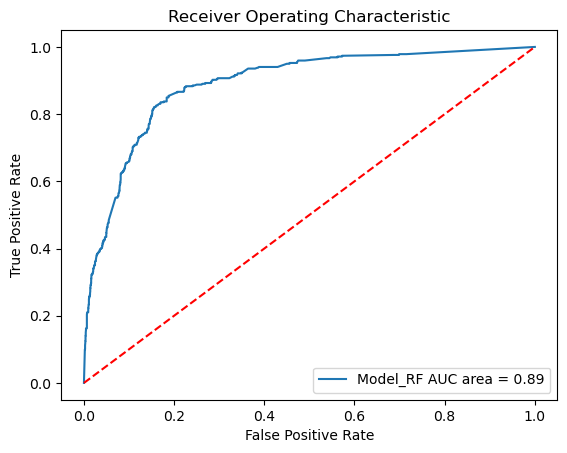

In [26]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
try:
    os.mkdir('results')
except:
    print("Directory already exists, continuing")
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

## Support vector classifier

In [27]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.53
Specificity: 0.94
AUC: 0.87


'/home/jovyan/final_data/results/roc_auc.png'

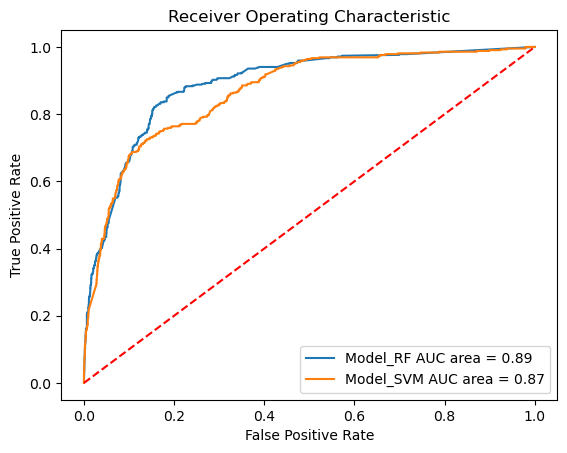

In [28]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

## Neural network classifier

In [29]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=12)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.37
Specificity: 0.95
AUC: 0.85


'/home/jovyan/final_data/results/roc_auc.png'

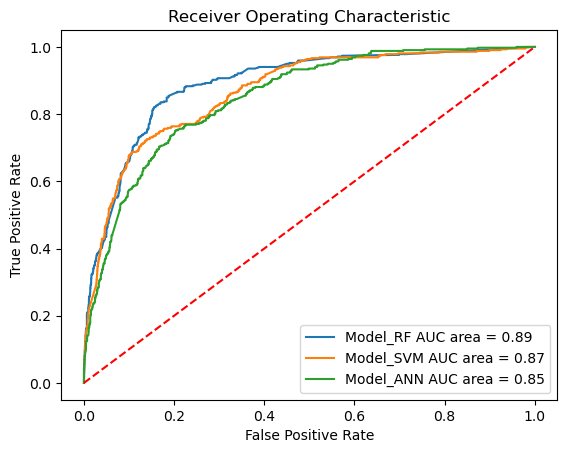

In [30]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

Now we have trained all three models. in the graph above we can see the ROC for all three models. The RF model seems to be slightly more predicive then the other 2. Next we perform cross-validation.

In [31]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

In [32]:
N_FOLDS = 5

In [33]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.87 	and std : 0.01 
Mean sensitivity: 0.60 	and std : 0.04 
Mean specificity: 0.93 	and std : 0.01 
Mean AUC: 0.89 	and std : 0.01 
Time taken : 5.72s


Model_SVM
Mean accuracy: 0.87 	and std : 0.00 
Mean sensitivity: 0.54 	and std : 0.05 
Mean specificity: 0.95 	and std : 0.01 
Mean AUC: 0.87 	and std : 0.01 
Time taken : 194.94s


Model_ANN
Mean accuracy: 0.86 	and std : 0.01 
Mean sensitivity: 0.51 	and std : 0.03 
Mean specificity: 0.94 	and std : 0.01 
Mean AUC: 0.87 	and std : 0.00 
Time taken : 24.57s



in the resulted cross-validation we can see that the RF model is indeed slightly more sensitive than the other 2 models.
However accuracy and specificy are high in all 3 models 

We will also check if there is a difference in performance for the models when we code with Morgan fingerprints.

In [34]:
# Reset data frame
compound_df = compound_df.drop(['fp'], axis=1)

In [35]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

Molecule ChEMBL ID  pChEMBL_value  \
0       CHEMBL519508            NaN   
1       CHEMBL486691            NaN   
2       CHEMBL270351            5.0   

                                              Smiles Assay_Type  \
0    CCOC(=O)c1c(Cc2cccc(F)c2)[nH]c2c1cc(O)c1ccccc12          B   
1        CCOC(=O)c1c(CCc2cccc(Cl)c2)[nH]c2ccc(O)cc12          B   
2  NS(=O)(=O)c1ccc(-c2nc(NCc3csc4ccccc34)cc(C(F)(...          B   

  Standard Relation  Standard Value  active  \
0               '='            71.0     0.0   
1               NaN             NaN     0.0   
2               '='         10000.0     0.0   

                                                  fp  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...

In [36]:
for model in models:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        pass
    print("\n=======")
    print(model["label"])
    reduced_df = compound_df[['active','fp']]
    crossvalidation(model["model"], reduced_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.87 	and std : 0.00 
Mean sensitivity: 0.57 	and std : 0.04 
Mean specificity: 0.94 	and std : 0.01 
Mean AUC: 0.89 	and std : 0.01 
Time taken : 53.25s


Model_SVM
Mean accuracy: 0.86 	and std : 0.00 
Mean sensitivity: 0.44 	and std : 0.05 
Mean specificity: 0.96 	and std : 0.01 
Mean AUC: 0.78 	and std : 0.02 
Time taken : 4148.27s


Model_ANN
Mean accuracy: 0.86 	and std : 0.00 
Mean sensitivity: 0.60 	and std : 0.05 
Mean specificity: 0.92 	and std : 0.01 
Mean AUC: 0.89 	and std : 0.00 
Time taken : 284.85s



The cross-validation shows the accuracy, sensitivity and specificity for all 3 models. ANN model seems to have a slightly better sensitivity than the other models. It can be seen that coding with Morgan fingerprints results in lower sensitivity than MACS fingerprints.

these models have been classification models. for the purpose of testing a new ligand I will make another model which will be a regression model.

In [37]:
def crossvalidation_reg(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    MAE_per_fold = []
    RMSE_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].pChEMBL_value.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].pChEMBL_value.tolist()
        
        test_results = fold_model.predict(test_x)
        # Prediction probability on test set
        from sklearn import metrics

        MAE_per_fold.append(metrics.mean_absolute_error(test_y, test_results))
        #print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_y, test_results))
        RMSE_per_fold.append(np.sqrt(metrics.mean_squared_error(test_y, test_results)))
        #mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
        #print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
        #print('Accuracy:', round(100*(1 - mape), 2))
    return(MAE_per_fold,RMSE_per_fold,fold_model)

In [38]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.pChEMBL_value.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 9673
Test data size: 2419


In [39]:
# Kick out NaN in the pChEMBL values
compound_df_noNaN = compound_df.dropna()

# Append RF Regressor model
#models.append({"label": "Model_RF_reg", "model": RandomForestRegressor})
#Train model with RandomForestRegressor
regressor = RandomForestRegressor()
MAE, RMSE,trained_model = crossvalidation_reg(regressor , compound_df_noNaN, n_folds=N_FOLDS)

print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
)

MAE: 0.55 	and std : 0.00 
RMSE: 0.78 	and std : 0.01 



Now that we have created different kind of models we will use the best model (RF) to predict the affinity of different ligands.

In [40]:
# The first entry is the co-crystalized ligand 
# which is added for reference (so we can compare 
# to its actual pChEMBL value)
# BELOW: add your own molecules
test_smiles = [
    
    'O=C(O)c1ccccc1O', #SALICYLIC ACID
    'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O', #ibuprofin
    'Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1', # CELECOXIB
    'COc1ccc2cc([C@H](C)C(=O)O)ccc2c1', #naproxen
    'CC(=O)Oc1ccccc1C(=O)O',  #asperin
    'NC(=O)c1ccccc1O', #test ligand 1
    'O=C(O)c1ccccc1-c1ccccc1C(=O)O' #test ligand 2
]

fps = []

for smiles in test_smiles: 
    fp = smiles_to_fp(smiles,'morgan3')
    fps.append(fp)

predictions = trained_model.predict(fps)
print("SMILES, PREDICTION")
for i, prediction in enumerate(predictions):
    print('{},{:.2f}'.format(test_smiles[i], prediction))

SMILES, PREDICTION
O=C(O)c1ccccc1O,5.34
CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,5.53
Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1,6.98
COc1ccc2cc([C@H](C)C(=O)O)ccc2c1,5.28
NC(=O)c1ccccc1O,5.37
O=C(O)c1ccccc1-c1ccccc1C(=O)O,5.60


# Docking

now that we have some predictions for a new ligand we can start docking, First we will tr

In [2]:
from pathlib import Path
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Docking')
except:
    print("Directory already exists")
os.chdir('Docking')

Directory already exists


we first gather the prepped files we created earlier. 

In [3]:
PDBCODE = '5F1A' # As in lab 1, change this to your PDB accession code.
LIGAND_CODE = 'SAL' # and add the ligand code
shutil.copy('../final_data/{}_prepped.pdb'.format(PDBCODE), '{}_prepped.pdb'.format(PDBCODE))
shutil.copy('../final_data/ligand-{}.pdb'.format(LIGAND_CODE), 'ligand-{}.pdb'.format(LIGAND_CODE))

'ligand-SAL.pdb'

In [14]:
test_smiles = [
    
    'O=C(O)c1ccccc1O', #SALICYLIC ACID
    'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O', #ibuprofin
    'Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1', # CELECOXIB
    'COc1ccc2cc([C@H](C)C(=O)O)ccc2c1', #naproxen
    'CC(=O)Oc1ccccc1C(=O)O',  #asperin
    'NC(=O)c1ccccc1O', #test ligand 1
    'O=C(O)c1ccccc1-c1ccccc1C(=O)O' #test ligand 2                      #asperin
]

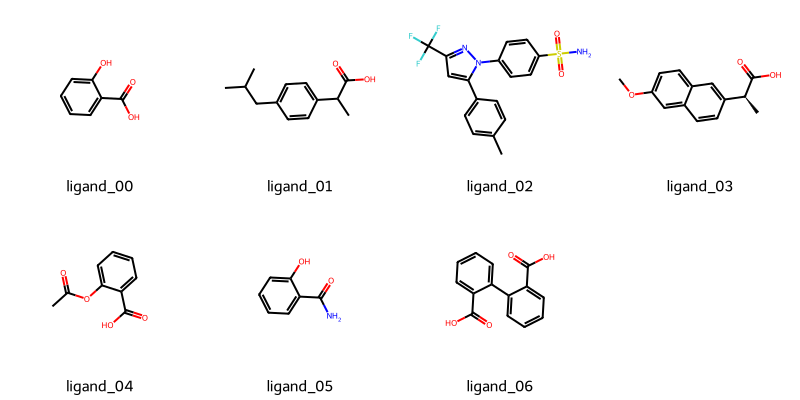

In [5]:
i = -1

IDs = []
for i in range(0,len(test_smiles)):
    base = 'ligand_{:02d}'.format(i)
    IDs.append(base)
    
df = pd.DataFrame({'ID':IDs, 'SMILES':test_smiles})

df['rdkit_mol'] = [Chem.MolFromSmiles(s) for s in df['SMILES']]

# Generate 2D images of the molecules
img=Draw.MolsToGridImage(df['rdkit_mol'].tolist(),
                            molsPerRow=4,
                            subImgSize=(200,200),
                            legends=df['ID'].tolist())

for i in range(len(df)):
    row = df.iloc[i]
    mol = row['rdkit_mol']
    name = row['ID'] + '.mol'
    Chem.MolToMolFile(mol,name)

img


In the picture above you can see the ligands that have been predicted. The last 2 are newly designed ligands. Now we will visualize the target protein with the co-crystalized ligand. The ligans will be shown in magenta.

In [6]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(PDBCODE),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('ligand_00.mol','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModelsAsFrames(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

now I will use Autodock Vina to recalculate the docking site to see how Autodock will perform.

In [7]:
from math import isnan, isinf

def PDBQTAtomLines(mol, donors, acceptors):
    """Create a list with PDBQT atom lines for each atom in molecule. Donors
    and acceptors are given as a list of atom indices.
    """

    atom_lines = [line.replace('HETATM', 'ATOM  ')
                  for line in Chem.MolToPDBBlock(mol).split('\n')
                  if line.startswith('HETATM') or line.startswith('ATOM')]

    pdbqt_lines = []
    for idx, atom in enumerate(mol.GetAtoms()):
        pdbqt_line = atom_lines[idx][:56]

        pdbqt_line += '0.00  0.00    '  # append empty vdW and ele
        # Get charge
        charge = 0.
        fields = ['_MMFF94Charge', '_GasteigerCharge', '_TriposPartialCharge']
        for f in fields:
            if atom.HasProp(f):
                charge = atom.GetDoubleProp(f)
                break
        # FIXME: this should not happen, blame RDKit
        if isnan(charge) or isinf(charge):
            charge = 0.
        pdbqt_line += ('%.3f' % charge).rjust(6)

        # Get atom type
        pdbqt_line += ' '
        atomicnum = atom.GetAtomicNum()
        if atomicnum == 6 and atom.GetIsAromatic():
            pdbqt_line += 'A'
        elif atomicnum == 7 and idx in acceptors:
            pdbqt_line += 'NA'
        elif atomicnum == 8 and idx in acceptors:
            pdbqt_line += 'OA'
        elif atomicnum == 1 and atom.GetNeighbors()[0].GetIdx() in donors:
            pdbqt_line += 'HD'
        else:
            pdbqt_line += atom.GetSymbol()
        pdbqt_lines.append(pdbqt_line)
    return pdbqt_lines

def MolToPDBQTBlock(mol, flexible=True, addHs=False, computeCharges=False):
    """Write RDKit Molecule to a PDBQT block

    Parameters
    ----------
        mol: rdkit.Chem.rdchem.Mol
            Molecule with a protein ligand complex
        flexible: bool (default=True)
            Should the molecule encode torsions. Ligands should be flexible,
            proteins in turn can be rigid.
        addHs: bool (default=False)
            The PDBQT format requires at least polar Hs on donors. By default Hs
            are added.
        computeCharges: bool (default=False)
            Should the partial charges be automatically computed. If the Hs are
            added the charges must and will be recomputed. If there are no
            partial charge information, they are set to 0.0.

    Returns
    -------
        block: str
            String wit PDBQT encoded molecule
    """
    # make a copy of molecule
    mol = Chem.Mol(mol)

    # if flexible molecule contains multiple fragments write them separately
    if flexible and len(Chem.GetMolFrags(mol)) > 1:
        return ''.join(MolToPDBQTBlock(frag, flexible=flexible, addHs=addHs,
                                       computeCharges=computeCharges)
                       for frag in Chem.GetMolFrags(mol, asMols=True))

    # Identify donors and acceptors for atom typing
    # Acceptors
    patt = Chem.MolFromSmarts('[$([O;H1;v2]),'
                              '$([O;H0;v2;!$(O=N-*),'
                              '$([O;-;!$(*-N=O)]),'
                              '$([o;+0])]),'
                              '$([n;+0;!X3;!$([n;H1](cc)cc),'
                              '$([$([N;H0]#[C&v4])]),'
                              '$([N&v3;H0;$(Nc)])]),'
                              '$([F;$(F-[#6]);!$(FC[F,Cl,Br,I])])]')
    acceptors = list(map(lambda x: x[0],
                         mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    # Donors
    patt = Chem.MolFromSmarts('[$([N&!H0&v3,N&!H0&+1&v4,n&H1&+0,$([$([Nv3](-C)(-C)-C)]),'
                              '$([$(n[n;H1]),'
                              '$(nc[n;H1])])]),'
                              # Guanidine can be tautormeic - e.g. Arginine
                              '$([NX3,NX2]([!O,!S])!@C(!@[NX3,NX2]([!O,!S]))!@[NX3,NX2]([!O,!S])),'
                              '$([O,S;H1;+0])]')
    donors = list(map(lambda x: x[0],
                      mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    if addHs:
        mol = Chem.AddHs(mol, addCoords=True, onlyOnAtoms=donors, )
    if addHs or computeCharges:
        AllChem.ComputeGasteigerCharges(mol)

    atom_lines = PDBQTAtomLines(mol, donors, acceptors)
    assert len(atom_lines) == mol.GetNumAtoms()

    pdbqt_lines = []

    # vina scores
    if (mol.HasProp('vina_affinity') and mol.HasProp('vina_rmsd_lb') and
            mol.HasProp('vina_rmsd_lb')):
        pdbqt_lines.append('REMARK VINA RESULT:  ' +
                           ('%.1f' % float(mol.GetProp('vina_affinity'))).rjust(8) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_lb'))).rjust(11) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_ub'))).rjust(11))

    pdbqt_lines.append('REMARK  Name = ' +
                       (mol.GetProp('_Name') if mol.HasProp('_Name') else ''))
    if flexible:
        # Find rotatable bonds
        rot_bond = Chem.MolFromSmarts('[!$(*#*)&!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])&'
                                      '!$([CD3](=[N,O,S])-!@[#7,O,S!D1])&'
                                      '!$([#7,O,S!D1]-!@[CD3]=[N,O,S])&'
                                      '!$([CD3](=[N+])-!@[#7!D1])&'
                                      '!$([#7!D1]-!@[CD3]=[N+])]-!@[!$(*#*)&'
                                      '!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])]')
        bond_atoms = list(mol.GetSubstructMatches(rot_bond))
        num_torsions = len(bond_atoms)

        # Active torsions header
        pdbqt_lines.append('REMARK  %i active torsions:' % num_torsions)
        pdbqt_lines.append('REMARK  status: (\'A\' for Active; \'I\' for Inactive)')
        for i, (a1, a2) in enumerate(bond_atoms):
            pdbqt_lines.append('REMARK%5.0i  A    between atoms: _%i  and  _%i'
                               % (i + 1, a1 + 1, a2 + 1))

        # Fragment molecule on bonds to ge rigid fragments
        bond_ids = [mol.GetBondBetweenAtoms(a1, a2).GetIdx()
                    for a1, a2 in bond_atoms]
        if bond_ids:
            mol_rigid_frags = Chem.FragmentOnBonds(mol, bond_ids, addDummies=False)
        else:
            mol_rigid_frags = mol
        frags = list(Chem.GetMolFrags(mol_rigid_frags))

        def weigh_frags(frag):
            """sort by the fragment size and the number of bonds (secondary)"""
            num_bonds = 0
            # bond_weight = 0
            for a1, a2 in bond_atoms:
                if a1 in frag or a2 in frag:
                    num_bonds += 1
                    # for frag2 in frags:
                    #     if a1 in frag2 or a2 in frag2:
                    #         bond_weight += len(frag2)

            # changed signs are fixing mixed sorting type (ascending/descending)
            return -len(frag), -num_bonds,  # bond_weight
        frags = sorted(frags, key=weigh_frags)

        # Start writting the lines with ROOT
        pdbqt_lines.append('ROOT')
        frag = frags.pop(0)
        for idx in frag:
            pdbqt_lines.append(atom_lines[idx])
        pdbqt_lines.append('ENDROOT')

        # Now build the tree of torsions usign DFS algorithm. Keep track of last
        # route with following variables to move down the tree and close branches
        branch_queue = []
        current_root = frag
        old_roots = [frag]

        visited_frags = []
        visited_bonds = []
        while len(frags) > len(visited_frags):
            end_branch = True
            for frag_num, frag in enumerate(frags):
                for bond_num, (a1, a2) in enumerate(bond_atoms):
                    if (frag_num not in visited_frags and
                        bond_num not in visited_bonds and
                        (a1 in current_root and a2 in frag or
                         a2 in current_root and a1 in frag)):
                        # direction of bonds is important
                        if a1 in current_root:
                            bond_dir = '%i %i' % (a1 + 1, a2 + 1)
                        else:
                            bond_dir = '%i %i' % (a2 + 1, a1 + 1)
                        pdbqt_lines.append('BRANCH %s' % bond_dir)
                        for idx in frag:
                            pdbqt_lines.append(atom_lines[idx])
                        branch_queue.append('ENDBRANCH %s' % bond_dir)

                        # Overwrite current root and stash previous one in queue
                        old_roots.append(current_root)
                        current_root = frag

                        # remove used elements from stack
                        visited_frags.append(frag_num)
                        visited_bonds.append(bond_num)

                        # mark that we dont want to end branch yet
                        end_branch = False
                        break
                    else:
                        continue
                    break  # break the outer loop as well

            if end_branch:
                pdbqt_lines.append(branch_queue.pop())
                if old_roots:
                    current_root = old_roots.pop()
        # close opened branches if any is open
        while len(branch_queue):
            pdbqt_lines.append(branch_queue.pop())
        pdbqt_lines.append('TORSDOF %i' % num_torsions)
    else:
        pdbqt_lines.extend(atom_lines)

    return '\n'.join(pdbqt_lines)

def MolFromPDBQTBlock(filename, sanitize=True, removeHs=True):
    """Read PDBQT block to a RDKit Molecule
    Parameters
    ----------
        block: string
            Residue name which explicitly pint to a ligand(s).
        sanitize: bool (default=True)
            Should the sanitization be performed
        removeHs: bool (default=True)
            Should hydrogens be removed when reading molecule.
    Returns
    -------
        mol: rdkit.Chem.rdchem.Mol
            Molecule read from PDBQT
    """
    pdb_lines = []
    name = ''
    data = {}
    with open(filename) as file:
        lines = file.readlines()
        block = [line.rstrip() for line in lines]
        
    for line in block: #.split('\n'):
        # Get all know data from REMARK section
        if line[:12] == 'REMARK  Name':
            name = line[15:].strip()
        elif line[:18] == 'REMARK VINA RESULT':
            tmp = line[19:].split()
            data['vina_affinity'] = tmp[0]
            data['vina_rmsd_lb'] = tmp[1]
            data['vina_rmsd_ub'] = tmp[2]

        # no more data to collect
        if line[:4] != 'ATOM':
            continue

        pdb_line = line[:56]
        pdb_line += '1.00  0.00           '

        # Do proper atom type lookup
        atom_type = line[71:].split()[1]
        if atom_type == 'A':
            atom_type = 'C'
        elif atom_type[:1] == 'O':
            atom_type = 'O'
        elif atom_type[:1] == 'H':
            atom_type = 'H'
            if removeHs:
                continue
        elif atom_type == 'NA':
            atom_type = 'N'

        pdb_lines.append(pdb_line + atom_type)
    mol = Chem.MolFromPDBBlock('\n'.join(pdb_lines), sanitize=False)
    if sanitize:
        Chem.SanitizeMol(mol)
    else:
        Chem.GetSSSR(mol)
    # reorder atoms using serial
    new_order = sorted(range(mol.GetNumAtoms()),
                       key=lambda i: (mol.GetAtomWithIdx(i)
                                      .GetPDBResidueInfo()
                                      .GetSerialNumber()))
    mol = Chem.RenumberAtoms(mol, new_order)

    # properties must be set on final copy of Mol, RenumberAtoms purges data
    mol.SetProp('_Name', name)
    for k, v in data.items():
        mol.SetProp(str(k), str(v))

    return mol

In [8]:
import math

def Rg(filename):
    '''
    Calculates the Radius of Gyration (Rg) of a protein given its .pdb 
    structure file. Returns the Rg integer value in Angstrom.
    '''
    coord = list()
    mass = list()
    Structure = open(filename, 'r')
    for line in Structure:
        try:
            line = line.split()
            x = float(line[6])
            y = float(line[7])
            z = float(line[8])
            coord.append([x, y, z])
            if line[-1] == 'C':
                mass.append(12.0107)
            elif line[-1] == 'O':
                mass.append(15.9994)
            elif line[-1] == 'N':
                mass.append(14.0067)
            elif line[-1] == 'S':
                mass.append(32.065)
        except:
            pass
    xm = [(m*i, m*j, m*k) for (i, j, k), m in zip(coord, mass)]
    tmass = sum(mass)
    rr = sum(mi*i + mj*j + mk*k for (i, j, k), (mi, mj, mk) in zip(coord, xm))
    mm = sum((sum(i) / tmass)**2 for i in zip(*xm))
    rg = math.sqrt(rr / tmass-mm)
    return(round(rg, 3))

# Calculate the center based on the reference ligand
Rg = Rg('ligand-{}.pdb'.format(LIGAND_CODE))
print("Radius of Gyration = {}".format(Rg))

Radius of Gyration = 22.45


In [9]:
# Calculate center of geometry
def COG(pdbfile, include='ATOM,HETATM'):
    """
    Calculates center of geometry of a protein and/or ligand structure.
    Returns:
        center (list): List of float coordinates [x,y,z] that represent the
        center of geometry (precision 3).
    """

    center = [None, None, None]
    include = tuple(include.split(','))

    with open(pdbfile) as pdb:

        # extract coordinates [ [x1,y1,z1], [x2,y2,z2], ... ]
        coordinates = []
        for line in pdb:
            if line.startswith(include):
                coordinates.append([float(line[30:38]),    # x_coord
                                    float(line[38:46]),    # y_coord
                                    float(line[46:54])     # z_coord
                                   ])

        # calculate center of geometry
        center = [sum([coordinates[i][j]/(len(coordinates))
              for i in range(len(coordinates))]) for j in range(3)]
        center = [round(center[i], 3) for i in range(3)]
    return center

CenterOfGeometry = COG('ligand-{}.pdb'.format(LIGAND_CODE))
print("Center Of Geometry = {}".format(CenterOfGeometry))

Center Of Geometry = [39.783, 20.715, 218.064]


In [10]:
protein = Chem.MolFromPDBFile('{}_prepped.pdb'.format(PDBCODE))
a = MolToPDBQTBlock(protein,flexible=False)
with open('protein.pdbqt','w') as outfile:
    for line in a:
        outfile.write(line)

In [11]:
# You can change the ligand name for each of the generated molecules from your smiles:
# So, ligand_00 (Should be the reference ligand from the crystal structure)
# Then, ligand_01, ligand_02, ... etc.
# Run one ligand at the time!
LIGAND_TO_DOCK = 'ligand_01' # Write the ligand you want to dock here.
m = Chem.MolFromMolFile('{}.mol'.format(LIGAND_TO_DOCK))
a = MolToPDBQTBlock(m)
with open('{}.pdbqt'.format(LIGAND_TO_DOCK), 'w') as outfile:
    for line in a:
        outfile.write(line)

In [12]:
v = Vina(sf_name='vina')

v.set_receptor('protein.pdbqt')

v.set_ligand_from_file('{}.pdbqt'.format(LIGAND_TO_DOCK))

center = {
     'center_x' : CenterOfGeometry[0], 
     'center_y' : CenterOfGeometry[1], 
     'center_z' : CenterOfGeometry[2]
     
}

size = { 
    'size_x' : Rg * 2.9 ,
    'size_y' : Rg * 2.9,
    'size_z' : Rg * 2.9,           
           }
 

v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                    box_size=[size['size_x'], size['size_y'], size['size_z']])

'''
# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
'''

# Dock the ligand
v.dock(exhaustiveness=10, n_poses=10)
v.write_poses('docking_results.pdbqt', n_poses=1, overwrite=True)

Computing Vina grid ... done.
Performing docking (random seed: -637384553) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


Now that the docking is complete I will calculate the affinity using Autodock vina to compare with the results from the trained model. 

In [13]:
# Create a mol object from the docking results, write the mol to file and print the predicted affinity
mol = MolFromPDBQTBlock('docking_results.pdbqt',sanitize=False)
Chem.rdmolfiles.MolToPDBFile(mol, '{}_docked.pdb'.format(LIGAND_TO_DOCK))
Ki = (math.exp(float(mol.GetProp('vina_affinity'))/0.592))
pKi = -math.log10(Ki)
pChEMBL = pKi
print('The affinity predicted by Vina = {} (kcal/mol)'.format(mol.GetProp('vina_affinity')))
print('Which (approximately) corresponds to a pChEMBL of {:.2f}'.format(pKi))

The affinity predicted by Vina = -6.630 (kcal/mol)
Which (approximately) corresponds to a pChEMBL of 4.86


autodock predicts a pChEMBL of 4.86 while the trained model predicts 5.34. to see if I can explain the difference in prediction I will visualize the calculated docking.

In [15]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(PDBCODE),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = '{}_docked.pdb'.format(LIGAND_TO_DOCK)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

Reference: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

As can be seen the calculated docking has resulted in a different docking location and pose as the co-crystalyzed structure. This means Autodock vina is not accurate in prediction the docking location for this molecule which could explain the difference in predicted pCHEMBL values. To investigate I have also tried docking Naproxen to see if it can dock that ligand more accuratly. This has been done using the same code. for reading clarity and to make sure the code keeps running correctly I will nog repeat the same code but insert a picture of the docking.

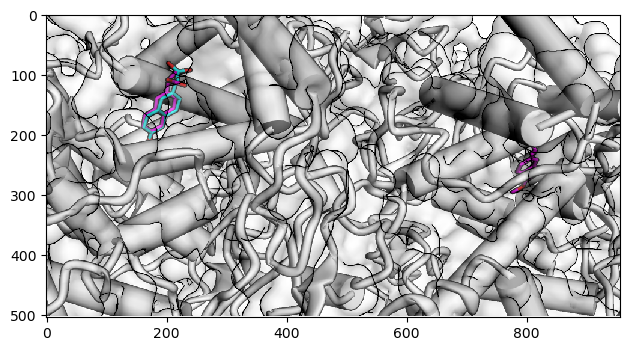

In [17]:
img = io.imread("naproxen_docking.png")
io.imshow(img)

It can been seen that naproxen is docking correctly. After done multiple rounds of docking it seems to be the case that orthosteric ligands are docked incorrectly and allosteric binders are docked correctly. This is interessting however I do not know the reason for this. This is a good example why you should be carefull with comptational data and you should always validate the predicted values. 

Because of these finding I wanted to try to dock a ligand that was structurely between the know orthosteric and allesteric ligands. I did this by making a ligans that resembled salicylate acid but make it more bulkier so I stacked 2 salicylate acid molecules together creating ligand_06. Docking resulted in the following

In [18]:
# You can change the ligand name for each of the generated molecules from your smiles:
# So, ligand_00 (Should be the reference ligand from the crystal structure)
# Then, ligand_01, ligand_02, ... etc.
# Run one ligand at the time!
LIGAND_TO_DOCK = 'ligand_06' # Write the ligand you want to dock here.
m = Chem.MolFromMolFile('{}.mol'.format(LIGAND_TO_DOCK))
a = MolToPDBQTBlock(m)
with open('{}.pdbqt'.format(LIGAND_TO_DOCK), 'w') as outfile:
    for line in a:
        outfile.write(line)

In [19]:
v = Vina(sf_name='vina')

v.set_receptor('protein.pdbqt')

v.set_ligand_from_file('{}.pdbqt'.format(LIGAND_TO_DOCK))

center = {
     'center_x' : CenterOfGeometry[0], 
     'center_y' : CenterOfGeometry[1], 
     'center_z' : CenterOfGeometry[2]
     
}

size = { 
    'size_x' : Rg * 2.9 ,
    'size_y' : Rg * 2.9,
    'size_z' : Rg * 2.9,           
           }
 

v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                    box_size=[size['size_x'], size['size_y'], size['size_z']])

'''
# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
'''

# Dock the ligand
v.dock(exhaustiveness=10, n_poses=10)
v.write_poses('docking_results.pdbqt', n_poses=1, overwrite=True)


mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1        -6.63          0          0
   2       -6.583      26.45      27.61
   3       -6.542      26.49      27.67
   4        -6.19      26.87      28.34
   5       -6.184      1.807      2.522
   6       -6.092      3.444      6.657
   7       -6.079      29.23      30.48
   8       -6.073      29.51      30.81
   9       -5.985      48.08      49.29
  10       -5.982      48.27      49.42
Computing Vina grid ... done.
Performing docking (random seed: -1239221268) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [20]:
# Create a mol object from the docking results, write the mol to file and print the predicted affinity
mol = MolFromPDBQTBlock('docking_results.pdbqt',sanitize=False)
Chem.rdmolfiles.MolToPDBFile(mol, '{}_docked.pdb'.format(LIGAND_TO_DOCK))
Ki = (math.exp(float(mol.GetProp('vina_affinity'))/0.592))
pKi = -math.log10(Ki)
pChEMBL = pKi
print('The affinity predicted by Vina = {} (kcal/mol)'.format(mol.GetProp('vina_affinity')))
print('Which (approximately) corresponds to a pChEMBL of {:.2f}'.format(pKi))

The affinity predicted by Vina = -6.362 (kcal/mol)
Which (approximately) corresponds to a pChEMBL of 4.67


In [21]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(PDBCODE),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = '{}_docked.pdb'.format(LIGAND_TO_DOCK)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

Reference: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

It can be seen that ligans_06 binds to a completlt differen location than both orthosteric and allosteric binders. This is remarkable. I have 3 hypothesis for this:

1. the ligans is a orthosteric binder and I have found that autodock can not predict those docking locations accuratly
2. The ligans is docked correctly and this is a different allosteric binding place than other tested ligands
3. The trained model was overfitted for this kind of ligands and the real affinity is much lower therefor Autodock did not dock it in the same place as other tested ligands.

It is not without reason the assume the third reason is true. The model was trained using a random split which is prone to overfitting. Autodock also calculated a much lower affinity for ligans_06 which indicates the real affinity might be lower than the model predicted. 

For future prospects it might be intersting to look into how Autodock tries to dock different kind of binders and how this can be fixed. It might also be a good idea to see if the trained model does handle the different binders correctly and the see how this may be approved. It can be a good idea to pre-select only orthosteric or allosteric binders and train a model with that data but idealy We train models in such way that they can do that themselfs.

ParserError: Error tokenizing data. C error: Expected 1 fields in line 21, saw 2
